# Neural Networks II: Deeper into model building, training and opmitization.

So far, we have built neural networks **completely from scratch**:

- We defined weights and biases as tensors.
- We computed predictions manually.
- We calculated the cost function by hand.
- We updated the parameters with gradient descent.


This is a great way to **learn how things work under the hood**. But in the real-world, doing everything manually is slow to write, easy to make mistakes and hard to scale. This is how defining a model through `nn.Module` in `PyTorch` will help us a lot!

By the end of this class, you will be able to:

- Understand PyTorch's `nn.Module` abstraction.
- Build a multi-layer perceptron (MLP) using `nn.Module`.
- Combine `nn.Module` with the built-in layers, cost functions functions and optimizers in `PyTorch`. 
- Train and evaluate a model.

In [2]:
# Imports for the class
import numpy as np
import torch
import torch.nn as nn

## 1. Defining a model through `nn.Module`

`nn.Module` is class that provides flexibility to build more complex models. `nn.Module` is the **base class for all neural network components** in PyTorch. 

Importantly, when a model is defined through the `nn.Module`, it automatically **registers its parameters (i.e. the weights)**, tracks them for gradient updates, and provides useful methods such as `.to(device)`, `.train()`, and `.eval()`. Therefore, it simplifies our life a lot!

Let's see how we can adapt our models with `nn.Module`:

### a. Signature of the class

Here, this class will inherit from `nn.Module`.  

In [3]:
class MyModel(nn.Module):
    pass

### b. `__init__()`

This is the **constructor of the class that defines the architecture (layers) of the model**. 

In this case we do not need to include the parameters explicitly. We can define them through particular layers (which we will explore next),  and then organize them in a list to control their order.

All these components are grouped using an `nn.ModuleList` —  a special container designed to hold multiple `nn.Module` objects.

In [4]:
class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 1)
        a2 = nn.Sigmoid()
        l = [l1, a1, l2, a2]
        self.module_list = nn.ModuleList(l)

Notice that we put all layers in the `nn.ModuleList` object, which is just a list object composed of `nn.Module` items. This makes the code more readable and easier to follow. 

For now, do not worry about the different components shown here (`nn.Linear`, `nn.ReLU`, etc...). we will come back to that nin a bit.

### c.`forward()` 

It defines the *computation*, i.e. it **implements how input data passes through the network**.  

In [5]:
class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 1)
        a2 = nn.Sigmoid()
        l = [l1, a1, l2, a2]
        self.module_list = nn.ModuleList(l)

    def forward(self, X):
        for f in self.module_list:
            X = f(X)
        return X

### Usage

Now we only need to instantiate the model and we can start using it!

In [6]:
# Instantiation
model = MyModel()

# Input data (it needs to have 2 features)
X = torch.Tensor([[0.1, 0.7], [0.1, 0.7]])

# And we can just pass this data to the model
model(X)

tensor([[0.5345],
        [0.5345]], grad_fn=<SigmoidBackward0>)

<div class="alert alert-block alert-info">
    
🧐🧐 **PAY ATTENTION** 🧐🧐

As you can, we were able to generate the output by just passing to the model object the input between parenthesis. That is, we did not need to call the method `forward` to do this. That's because our class is using implicitly.

💡**BUT**💡That is a capability of `nn.Module`, which we are inheriting from. See what happens if we don't inherit from this class and try to do the same:
</div>

In [7]:
class MyModelNoModule(object):

    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 1)
        a2 = nn.Sigmoid()
        l = [l1, a1, l2, a2]
        self.module_list = nn.ModuleList(l)

    def forward(self, X):
        for f in self.module_list:
            X = f(X)
        return X

In [8]:
model_2 = MyModelNoModule()
model_2(X)

TypeError: 'MyModelNoModule' object is not callable

it would only work if we explicitly call the method `forward`

In [9]:
model_2.forward(X)

tensor([[0.5457],
        [0.5457]], grad_fn=<SigmoidBackward0>)

> **Question**: Each time you run the cell where we instantiated and used the model you get a different output despite having the same input. Why do you think this is?
> 
> **Answer:**
> The weights are randomly initialized!

### Making the Most of `nn.Module`: Components of a Neural Network

Now that we understand what `nn.Module` is and why our model should inherit from it,  let’s look inside and explore the **key building blocks** that make up a neural network.

When defining the `__init__()` method, we saw that we can include elements such as:
- `nn.Linear` — layers that apply a linear transformation.
- `nn.ReLU`, `nn.Sigmoid`, etc. — activation functions that introduce non-linearity and generate output predictions.
- Other modules like `nn.Dropout`, `nn.BatchNorm1d`, etc. (next week!)

Each of these is itself a **subclass** of `nn.Module`, so they automatically register their own parameters (if they have any)  and integrate smoothly with the rest of PyTorch’s machinery.

Let's go now through these components one by one, to understand what each does and how they work together within our model.

#### Layers

Layers in `Pytorch` include transformations from one layer to the other of the neural network. 

These transformations typically depend on certain weights $W$. In `Pytorch` once you define a layer with its **architecture**, i.e. the expected number of inputs and ouputs, the weights are initialized to a random value.

**These weights are what we learn during training.**

In standard neural network we woud typically use `nn.Linear`, which is the usual linear transformation to the incoming data. Specifically, given an input sample with `in_features`, this would yield $k$ `out_features` as: $h_k = \sum_{j=1}^{\mbox{in\_features}} x_j W_{jk} + b_k$ 

This is a class, with arguments :
- `in_features` and `out_features` are the size of each input and output sample respectively.

In [10]:
# 1 input -> 2 outputs
m = nn.Linear(1, 2)
input = torch.tensor([1.0])
output = m(input)
print(output.size(), output)

torch.Size([2]) tensor([0.3036, 0.3042], grad_fn=<ViewBackward0>)


> **Question**: This layer was able to produce an output just passing the input in parenthesis. Why do you think this is?
>
>  **Answer:**
> We do need to call `.forward()`because `nn.Linear`is subclasses of `nn.Module`!. Using `layer(x)` also ensures that PyTorch’s automatic features (like gradient tracking) work correctly.

#### Activations

- `nn.Relu`

In [11]:
m = nn.ReLU()
input = torch.tensor([-0.1, 0.4, -0.3, 0.1])
output = m(input)
output

tensor([0.0000, 0.4000, 0.0000, 0.1000])

- `nn.Sigmoid`

In [12]:
m = nn.Sigmoid()
input = torch.tensor([-0.9, 0., -5, 5])
output = m(input)
output

tensor([0.2891, 0.5000, 0.0067, 0.9933])

- `nn.Tanh`: Hyperbolic Tangent (Tanh) function

In [13]:
m = nn.Tanh()
input = torch.tensor([-0.9, 0., -5, 5])
output = m(input)
output

tensor([-0.7163,  0.0000, -0.9999,  0.9999])

- `nn.Softmax`: softmax function to an n-dimensional input. This is the typical layer for multi-class problems!

In [14]:
m = nn.Softmax(dim=1)
input = torch.tensor([[-0.9, 0., -1, 1]])
output = m(input)
print(output)

print(output.sum())

tensor([[0.0905, 0.2226, 0.0819, 0.6050]])
tensor(1.0000)


> **Question**: Here again, we were able to produce an output just passing the input in parenthesis. Why do you think this is?
>
>  **Answer:**
> Because these activation functions from `nn` are also subclasses of `nn.Module`!

## 2. Training the model

This is when the created model is fitted with respect to our data (normally the training set).  During this process, our cost function is minimized, and the parameters of our model learned.

So far, we have been doing this for a given cost function (e.g. MSE) through a loop implementing stochastic gradient descent.

Now, since our model is a subclass of `nn.Module`, `PyTorch` already knows which parameters belong to it.   This allows us to fully leverage the `PyTorch` ecosystem — using its **built-in cost functions** and, more importantly, **optimizers** — to handle the entire training process automatically.

This means we no longer need to manually implement stochastic gradient descent.  Instead, we can use other and sometimes more flexible and effective optimizers (e.g.Adam), all of which directly access and update the parameters registered within our `nn.Module` model.

In [15]:
class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 10)
        a1 = nn.ReLU()
        l2 = nn.Linear(10, 1)
        a2 = nn.Sigmoid()
        l = [l1, a1, l2, a2]
        self.module_list = nn.ModuleList(l)

    def forward(self, X):
        for f in self.module_list:
            X = f(X)
        return X

In [17]:
# FYI: The previous one is the same as this one!
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


/home/javi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


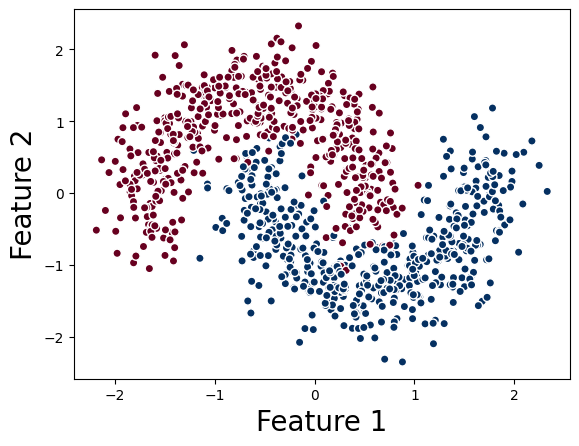

In [18]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

plt.scatter(X[:,0], X[:,1], c=y, cmap="RdBu", edgecolors='w', alpha=1)
plt.xlabel("Feature 1", size=20)
plt.ylabel("Feature 2", size=20)
plt.show()

During training, as we have seen, we aim to find the **model parameters** that minimize a **cost function** according to some optimization rule (e.g., stochastic gradient descent).

The good news is that, when our model is defined as a subclass of `nn.Module`, this task becomes **much simpler**.  

PyTorch automatically keeps track of all parameters in the model, allowing its built-in **loss functions** and **optimizers** to handle most of the heavy lifting for us.

Let's have a quick look at how this works in practice —  we will explore each component in detail right after.


In [34]:
from torch import optim

torch.manual_seed(1234)
# 1- instantiante the model
model = MyModel()

# 2- Define the cost function through nn
cost_function = nn.BCELoss() # This is the cost function
# 3- Define the optimization rule through optim module
optimizer = optim.SGD(model.parameters(), lr=0.01) # pay attention to the first argument!

n_epochs = 100
train_costs = []
test_costs = []

# And this is the typical training loop!
for epoch in range(n_epochs):
    model.train() # 
    running_cost = 0
    accuracy_hist_train = 0
    randperm = torch.randperm(X_train.shape[0])
    for ii in randperm:
        x_batch, y_batch = X_train[ii], y_train[ii]

        # 4- set the gradients to zero -- this is similar to the other day
        optimizer.zero_grad()
        # 5- compute outputs
        y_probs = model(x_batch)
        # 6- compute cost
        cost = cost_function(y_probs, y_batch)
        # 7- Calculate gradients
        cost.backward()
        # 8- Apply them to update the parameters
        optimizer.step()
        running_cost += cost.item()

    train_costs.append(running_cost / X_train.shape[0])

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}: Train Loss = {train_costs[-1]:.4f}")

Epoch 1: Train Loss = 0.4726
Epoch 11: Train Loss = 0.2515
Epoch 21: Train Loss = 0.1612
Epoch 31: Train Loss = 0.1177
Epoch 41: Train Loss = 0.1000
Epoch 51: Train Loss = 0.0886
Epoch 61: Train Loss = 0.0829
Epoch 71: Train Loss = 0.0769
Epoch 81: Train Loss = 0.0753
Epoch 91: Train Loss = 0.0730


So as you can see, the new ingredients here are:

- Importing a cost function from `nn`. This is barely a new change.
- Minimization of the cost function through an optimizer object. **This is a big and major advance! (Compare to previous lesson!)**

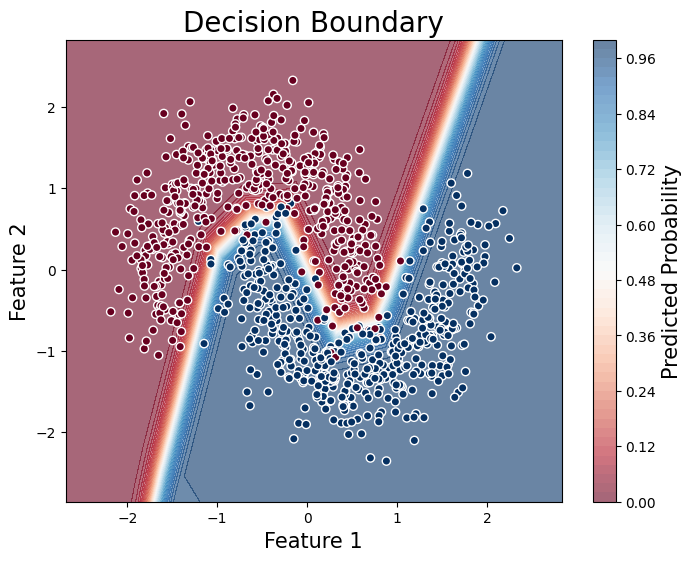

In [35]:
# Create a grid of points covering the feature space
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 1000),
    np.linspace(y_min, y_max, 1000)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Get model predictions on the grid
with torch.no_grad():
    probs = model(grid_tensor).numpy().reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.6)
cbar = plt.colorbar()
cbar.set_label("Predicted Probability", size=15)
cbar.ax.tick_params(labelsize=10)
# Overlay training data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdBu", edgecolors='w', alpha=1)
plt.title("Decision Boundary", size=20)
plt.xlabel("Feature 1", size=15)
plt.ylabel("Feature 2", size=15)
plt.show()

## 3. Testing the model

In [36]:
model.eval()  # Important: disable dropout, batchnorm, etc.
test_cost = 0.0
correct = 0
total = 0

with torch.no_grad():  # No gradient tracking
    for ii in range(X_test.shape[0]):
        x_batch, y_batch = X_test[ii], y_test[ii]
        probs = model(x_batch)
        cost = cost_function(probs, y_batch)
        test_cost += cost.item() 
        predictions = (probs > 0.5).float() 
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)

avg_test_loss = test_cost / total
accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2%}")

Test Loss: 0.0431, Test Accuracy: 98.50%


<div class="alert alert-block alert-info">

𝐈𝐌𝐏𝐎𝐑𝐓𝐀𝐍𝐓‼️ 

Technically, we did not need to test each individual sample in the test set, especially if the data is small. We could have directly passed the whole test set.
</div>

In [37]:
# Using the whole test
from sklearn.metrics import accuracy_score

model.eval() # 
with torch.no_grad():
    probs = model.forward(X_test)
    test_cost = cost_function(probs, y_test)
    y_pred = (probs > 0.5).detach().numpy().flatten()
    
accuracy = accuracy_score(y_test.numpy(), y_pred)
print(f"Test Loss: {test_cost:.4f}, Test Accuracy: {accuracy:.2%}")

Test Loss: 0.0431, Test Accuracy: 98.50%


🚨🚨 But in practice, it is recommended to follow the same approach as in the training set when handling individual samples. This keeps your pipeline consistent and reduces the chance of confusion or bugs.

🚨🚨 In addition, as we will see later, when using batches (rather than single samples), this is both more memory- and computation-efficient, and it scales better for larger datasets and models.

### Cost functions

The module `nn` has a lot of implementations. Here are a few major and standard ones:

- `nn.MSELoss`: Mean squared error (squared L2 norm) between each element in the input x and target y. Cost function for **standard regression** tasks.
- `nn.BCELoss`: Binary Cross Entropy between the target and the input probabilities. Cost function for standard **binary classification** tasks.
- `nn.CrossEntropyLoss`: Cross entropy loss between input logits and target. It is useful in **multi-class classification** problems. (See documenation to check how it interact with the outputs)

You can check the [cost-functions documentation](https://docs.pytorch.org/docs/stable/nn.html#loss-functions) for more.

Let's suppose we are doing a multi-class classification task, so then we would choose a Cross Entropy Loss.

In [38]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

print(output)

tensor(1.5920, grad_fn=<NllLossBackward0>)


<div class="alert alert-block alert-info">

🧐 **Pay attention!!**

Do you know why we call `criterion(y_pred, y_true)` directly?

Because cost functions like `nn.MSELoss` are also subclasses of `nn.Module`!, which means that, like layers or models, calling them as a function automatically runs their `forward()` method:

</div>

In [41]:
loss.forward(input, target)

tensor(1.5920, grad_fn=<NllLossBackward0>)

### Optimizers

We will use `torch.optim`, which is a package implementing various optimization algorithms.

To use `torch.optim`, you need to define an optimizer object, which will hold the current state and will update the parameters based on the computed gradients.

This is the new part:

```python
optimizer = optim.Adam(model.parameters())
...
optimizer.zero_grad()
...
optimizer.step()
```
which replaced the part:

```python
with torch.no_grad():
    self.W_1 -= self.learning_rate * self.W_1.grad
    self.b_1 -= self.learning_rate * self.b_1.grad
    self.W_2 -= self.learning_rate * self.W_2.grad
    self.b_2 -= self.learning_rate * self.b_2.grad

    # Zero gradients
    self.W_1.grad.zero_()
    self.b_1.grad.zero_()
    self.W_2.grad.zero_()
    self.b_2.grad.zero_()
```

The following are the same optimizers that you can find for `MLPClassifier` and `MLPRegresssor` in `scikit-learn`

- `torch.optim.SGD`:  Stochastic Gradient Descent. Widely used in practice for both simple and deep models. It may lead to better generalization than adaptive methods (like Adam; see next) due its flexibility to tune parameters.

- `torch.optim.Adam`: Optimizer method that adapts the learning rate. Therefore, it typically requires minimal tuning. A default for deep learning. Requires minimal tuning.

- `torch.optim.LBFGS`:  A quasi-Newton method that approximates the inverse Hessian matrix. It is useful for smaller datasets and optimization problems requiring very precise convergence. Less commonly used in deep learning. 

`PyTorch` includes many more optimizers beyond the ones we've covered. You can find a more extensive list in [PyTorch's optimization algorithms](https://pytorch.org/docs/stable/optim.html#algorithms).

In practice, **SGD and Adam are by far the most commonly used**, and we will be using these two for the rest of the module on neural networks.

<div class="alert alert-block alert-warning">

**NOTE!!!**
    
`nn.LBFGS` requires a special mechanism called a *closure* during optimization, which makes it more cumbersome to use. If you're curious, you can read more about it in the [official PyTorch documentation](https://pytorch.org/docs/stable/optim.html#optimizer-step-closure).

</div>


<div class="alert alert-block alert-info">

𝐈𝐌𝐏𝐎𝐑𝐓𝐀𝐍𝐓‼️ 

The **first argument** to an optimizer is the set of **model parameters** — these are the values we want to update during training.

Because our model **inherits from `nn.Module`**, we can simply call `model.parameters()` to access them automatically.  
Otherwise, we would have to manually collect and pass all parameters, which is error-prone and cumbersome.

**This is yet another reason why we always define our models as subclasses of `nn.Module`!**

</div>

## 3. Improving Training with Batches using `DataLoader`

Up to now, we have been training our models so weights were being updated after using each individual training sample. This is the main behavior behind **Stochastic Gradient Descent**.

However, in practice, this can make training problematic due to:

- Slower and less stable convergence.
- Noisy gradient updates
  
We can improve this by using **batches** of training samples, i.e. by considering several samples simultaneously to update our parameters.

We will see that this is very easy to do in `PyTorch` through `DataLoader`.


In [45]:
from torch.utils.data import TensorDataset, DataLoader

# Define batch size
batch_size = 16

# Wrap the data in a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [46]:
from torch import optim

model = MyModel()

cost_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 100
train_costs = []
test_costs = []

for epoch in range(n_epochs):
    model.train() # 
    running_cost = 0
    accuracy_hist_train = 0
    #randperm = torch.randperm(X_train.shape[0])
    #for ii in randperm:
    for x_batch, y_batch in train_loader:
        #x_batch, y_batch = X_train[ii], y_train[ii]
        optimizer.zero_grad()
        y_probs = model(x_batch)
        cost = cost_function(y_probs, y_batch)
        cost.backward()
        optimizer.step()
        running_cost += cost.item()

    train_costs.append(running_cost / X_train.shape[0])

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}: Train Loss = {train_costs[-1]:.4f}")

Epoch 1: Train Loss = 0.0396
Epoch 11: Train Loss = 0.0212
Epoch 21: Train Loss = 0.0186
Epoch 31: Train Loss = 0.0180
Epoch 41: Train Loss = 0.0177
Epoch 51: Train Loss = 0.0175
Epoch 61: Train Loss = 0.0173
Epoch 71: Train Loss = 0.0171
Epoch 81: Train Loss = 0.0169
Epoch 91: Train Loss = 0.0166


With just a few lines of code, we have switched from stochastic to batch training!

`DataLoader` gives us clean and efficient batch processing, and prepares us to handle larger datasets in future labs.



In [47]:
model.eval()  # Important: disable dropout, batchnorm, etc.
test_cost = 0.0
correct = 0
total = 0

with torch.no_grad():  # No gradient tracking
    for x_batch, y_batch in test_loader:
        probs = model(x_batch)
        cost = cost_function(probs, y_batch)
        test_cost += cost.item() * x_batch.size(0)  
        predictions = (probs > 0.5).float() 
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)

avg_test_loss = test_cost / total
accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2%}")

Test Loss: 0.2551, Test Accuracy: 88.50%


In [48]:
from sklearn.metrics import accuracy_score
# Get model predictions on the grid
with torch.no_grad():
    probs = model.forward(X_test).detach().numpy().flatten()
    y_pred = (probs > 0.5)
print(accuracy_score(y_test.numpy(), y_pred))

0.885


## 4. Summary

- **`nn.Module`** provides an efficient and consistent framework to build neural networks.  
  It automatically registers parameters, connects layers, integrates with loss functions and optimizers,  
  and makes training pipelines clean and scalable.

- **Cost functions** from `torch.nn` simplify the computation of losses and work seamlessly with models built using `nn.Module`.

- **Optimizers** from `torch.optim` automatically update model parameters (retrieved through `model.parameters()`),  
  allowing flexible and reliable training beyond manual gradient descent.

- **`DataLoader`** allows for an efficient **batch processing**, shuffling, and iteration over large datasets —  
  essential for scalable and reproducible training.


## 📝 5. Exercises

### 5.1 Exercise — Adapting to Multiclass and Regression

Replicate the same architecture and training loop from class, but apply it to the following tasks:

1. **Multiclass Classification**
   - Use `sklearn.datasets.make_classification` 
   - Modify the final layer to output `n_classes` units
   - Use `nn.CrossEntropyLoss`
   - No activation function at the output (CrossEntropy expects raw logits)

2. **Regression**
   - Use `sklearn.datasets.make_regression`
   - Final layer should output a single unit
   - Use `nn.MSELoss`
   - No activation function at the output layer

In both cases, assume a batch size different than 1. 

🧠 *Hint*: Each task needs a different loss function and output layer. Be careful with data shapes and target formats.

In [327]:
#YOUR CODE

### 5.2 Exercise  — Compare Optimizers and Batch Sizes

Train the binary classification model from class using different optimizers:

- `torch.optim.SGD`
- `torch.optim.Adam`

Keep the same architecture, data, and number of epochs for each run. Compare:

- Final training loss
- Training stability (does one converge more smoothly than others?)
- Test accuracy (optional)

Also, experiment with different **batch sizes** (e.g., 1, 8, 32, 64) and compare:

- Training performance (e.g., convergence speed, final loss)
- Computational time

**Reflect**: What do you notice when using very small vs. very large batches? Which optimizer converges fastest? Which one performs best?

In [328]:
#YOUR CODE